# Preprocessing data

## Eco2mix

In [1]:
REGIONS = [
    "Auvergne-Rhône-Alpes",
    "Bourgogne-Franche-Comté",
    "Bretagne",
    "Centre-Val-de-Loire",
    "Grand-Est",
    "Hauts-de-France",
    "Ile-de-France",
    "Normandie",
    "Nouvelle-Aquitaine",
    "Occitanie",
    "PACA",
    "Pays-de-la-Loire"
]

FILETYPES = [
    "En-cours-Consolide",
    "En-cours-TR",
    "Annuel-Definitif_2013",
    "Annuel-Definitif_2014",
    "Annuel-Definitif_2015",
    "Annuel-Definitif_2016",
    "Annuel-Definitif_2017",
    "Annuel-Definitif_2018",
    "Annuel-Definitif_2019",
    "Annuel-Definitif_2020",
]


In [2]:
#imports des packages
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

warnings.filterwarnings("ignore")

In [3]:
#loop over regions and filetypes to create different dataframes
def add_conso_regional(region) :
    concat_df = pd.DataFrame()
    for filetype in FILETYPES:
        filename = f"./data/eco2mix/{region}/{filetype}.txt"
        df = pd.read_csv(filename, sep="\t", encoding="latin-1")
            #delete last row with comment of rte
        df = df[:-1]
        if filetype != "Annuel-Definitif_2019":
                #delete all columns except Date, Heure and Consommation
            df = df[["Date", "Heures", "Consommation"]]
        else:
                #delete all columns except Date, Heure and Consommation
            df = df[["Périmètre", "Nature", "Date"]]
            #rename columns
        df.columns = ["Date", "Heures", f"Consommation_{region}"]
            #put date and hour in index
        df = df.set_index(["Date", "Heures"])
        #delete all rows with NaN values
        df = df.dropna()
        #concatenate all dataframes
        concat_df = pd.concat([concat_df, df], axis=0)
        #replace nd by nan
        concat_df = concat_df.replace("ND", np.nan)
        concat_df[f"Consommation_{region}"] = concat_df[f"Consommation_{region}"].astype(float)
        concat_df = concat_df.sort_index()
    return concat_df

In [4]:
#loop for each region of regions and stock dataframe for each region
conso_regional = pd.DataFrame()

for region in REGIONS:
    data = add_conso_regional(region)
    #concat dataframes for each region
    conso_regional = pd.concat([conso_regional, data], axis=1)
    #replace nan 
    conso_regional = conso_regional.fillna(method="bfill")

#reset index and create column index
conso_regional = conso_regional.reset_index()
conso_regional = conso_regional[~conso_regional["Heures"].str.contains("5")]
conso_regional["index"] = pd.to_datetime(conso_regional["Date"] + " " + conso_regional["Heures"])
#delete columns Date and Heures
conso_regional = conso_regional.drop(["Date", "Heures"], axis=1)


In [5]:
conso_regional

,Consommation_Auvergne-Rhône-Alpes,Consommation_Bourgogne-Franche-Comté,Consommation_Bretagne,Consommation_Centre-Val-de-Loire,Consommation_Grand-Est,Consommation_Hauts-de-France,Consommation_Ile-de-France,Consommation_Normandie,Consommation_Nouvelle-Aquitaine,Consommation_Occitanie,Consommation_PACA,Consommation_Pays-de-la-Loire,index
0,8173.0,2357.0,3050.0,2476.0,4943.0,5989.0,9134.0,3683.0,5464.0,5228.0,5570.0,3595.0,2013-01-01 00:00:00
1,8173.0,2357.0,3050.0,2476.0,4943.0,5989.0,9134.0,3683.0,5464.0,5228.0,5570.0,3595.0,2013-01-01 00:30:00
2,7944.0,2289.0,2866.0,2319.0,4811.0,5832.0,8822.0,3549.0,5422.0,4955.0,5698.0,3359.0,2013-01-01 01:00:00
3,7896.0,2326.0,2735.0,2560.0,4840.0,5926.0,8499.0,3570.0,5514.0,4888.0,5680.0,3313.0,2013-01-01 01:30:00
4,7882.0,2409.0,2874.0,2395.0,4897.0,5695.0,8229.0,3569.0,5443.0,4881.0,5577.0,3383.0,2013-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219482,8553.0,2663.0,2767.0,2334.0,5444.0,5965.0,9186.0,3162.0,5545.0,5422.0,4946.0,4035.0,2023-12-20 06:30:00
219484,8872.0,2777.0,2957.0,2583.0,5612.0,6225.0,9588.0,3339.0,5999.0,5634.0,5137.0,4104.0,2023-12-20 07:00:00
219486,8950.0,2855.0,3072.0,2630.0,5675.0,6336.0,10289.0,3407.0,6348.0,5818.0,5205.0,4148.0,2023-12-20 07:30:00
219488,9214.0,2910.0,3129.0,2772.0,5844.0,6601.0,10699.0,3469.0,6754.0,5979.0,5331.0,4081.0,2023-12-20 08:00:00


In [6]:
#check nan
conso_regional.isna().sum()

Consommation_Auvergne-Rhône-Alpes       0
Consommation_Bourgogne-Franche-Comté    0
Consommation_Bretagne                   0
Consommation_Centre-Val-de-Loire        0
Consommation_Grand-Est                  0
Consommation_Hauts-de-France            0
Consommation_Ile-de-France              0
Consommation_Normandie                  0
Consommation_Nouvelle-Aquitaine         0
Consommation_Occitanie                  0
Consommation_PACA                       0
Consommation_Pays-de-la-Loire           0
index                                   0
dtype: int64

In [7]:
#loop over regions and filetypes to create different dataframes
#création d'un dataframe de la consommation nationale d'électricité d'une boucle sur les régions et les types de fichiers de consommation
conso_national = pd.DataFrame()

for filetype in FILETYPES:
    filename = f"./data/eco2mix/France/{filetype}.txt"
    df = pd.read_csv(filename, sep="\t", encoding="latin-1", on_bad_lines='skip')
    df = df[:-1]
    if filetype == "En-cours-Consolide":
        #delete all columns except Date, Heure and Consommation
        df = df[["Date", "Heures", "Consommation"]]
    else:
        #delete all columns except Date, Heure and Consommation
        df = df[["Nature", "Date", "Heures"]]
    #rename columns
    df.columns = ["Date", "Heures", "Consommation"]
    #delete rows heures with a 5 in minutes
    df = df[~df["Heures"].str.contains(":.5")]
    #put date and hour in index
    df = df.set_index(["Date", "Heures"])
    #delete all rows with NaN values
    df = df.dropna()
    conso_national = pd.concat([conso_national, df], axis=0)
print(conso_national.sort_index())

                   Consommation
Date       Heures              
2013-01-01 00:00        61194.0
           00:30        59674.0
           01:00        57877.0
           01:30        57755.0
           02:00        57243.0
...                         ...
2023-12-20 12:00        66012.0
           12:30        64891.0
           13:00        63859.0
           13:30        63326.0
           14:00        63009.0

[187853 rows x 1 columns]


In [8]:
#change index to columns date and heures and keep only rows heures without a 5 in minutes
conso_national = conso_national.sort_index()
conso_national = conso_national.reset_index()
conso_national = conso_national[~conso_national["Heures"].str.contains("5")]
conso_national = conso_national.set_index(["Date", "Heures"])
#concat date et heures columns and reset index
conso_national = conso_national.reset_index()
conso_national["index"] = conso_national["Date"] + " " + conso_national["Heures"]
#delete date and heures columns$
conso_national = conso_national.drop(columns=["Date", "Heures"])
print(conso_national)

        Consommation             index
0            61194.0  2013-01-01 00:00
1            59674.0  2013-01-01 00:30
2            57877.0  2013-01-01 01:00
3            57755.0  2013-01-01 01:30
4            57243.0  2013-01-01 02:00
...              ...               ...
172194       66012.0  2023-12-20 12:00
172195       64891.0  2023-12-20 12:30
172196       63859.0  2023-12-20 13:00
172197       63326.0  2023-12-20 13:30
172198       63009.0  2023-12-20 14:00

[172199 rows x 2 columns]


In [9]:
#check nan
conso_national.isna().sum()

Consommation    0
index           0
dtype: int64

## Meteo (temperature)

In [10]:
FILETYPES = [
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
]

FILES = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
]

In [11]:
meteo = pd.DataFrame()

for filetype in FILETYPES:
    for file in FILES:
        filename = f"./data/meteo/{filetype}/{file}.csv"
        df = pd.read_csv(filename, sep=";")
        df = df[["numer_sta", "date", "t"]]
        #rename columns
        df.columns = ["id_station", "Date", "Temperature"]
        #delete rows by some id_station
        df = df[df.id_station != 7761]
        df = df[df.id_station != 7790]
        df = df[df.id_station != 7207]
        df = df[df.id_station != 61968]
        df = df[df.id_station != 61970]
        df = df[df.id_station != 61972]
        df = df[df.id_station != 61976]
        df = df[df.id_station != 61980]
        df = df[df.id_station != 61996]
        df = df[df.id_station != 61997]
        df = df[df.id_station != 61998]
        df = df[df.id_station != 67005]
        df = df[df.id_station != 71805]
        df = df[df.id_station != 78890]
        df = df[df.id_station != 78894]
        df = df[df.id_station != 78897]
        df = df[df.id_station != 78922]
        df = df[df.id_station != 78925]
        df = df[df.id_station != 81401]
        df = df[df.id_station != 81405]
        df = df[df.id_station != 81408]
        df = df[df.id_station != 81415]
        df = df[df.id_station != 89642]
    meteo = pd.concat([meteo, df], axis=0)
print(meteo)


      id_station            Date Temperature
0           7005  20131201000000  278.550000
1           7015  20131201000000  278.450000
2           7020  20131201000000  282.350000
3           7027  20131201000000  277.650000
4           7037  20131201000000  277.750000
...          ...             ...         ...
9138        7643  20231219180000  282.550000
9139        7650  20231219180000  279.850000
9140        7661  20231219180000          mq
9141        7690  20231219180000  282.550000
9142        7747  20231219180000  281.850000

[101870 rows x 3 columns]


In [12]:
#reformat date column in meteo
meteo["Date"] = pd.to_datetime(meteo["Date"], format="%Y%m%d%H%M%S")
#replace mq by NaN
meteo["Temperature"] = meteo["Temperature"].replace("mq", np.nan)
#convert temperature from string to float
meteo["Temperature"] = meteo["Temperature"].astype(float)
#replace nan by mean of temperature before and after
meteo["Temperature"] = meteo["Temperature"].fillna((meteo["Temperature"].shift() + meteo["Temperature"].shift(-1))/2)
#convert temperature from kelvin to celsius
meteo["Temperature"] = meteo["Temperature"] - 273.15

print(meteo)

      id_station                Date  Temperature
0           7005 2013-12-01 00:00:00         5.40
1           7015 2013-12-01 00:00:00         5.30
2           7020 2013-12-01 00:00:00         9.20
3           7027 2013-12-01 00:00:00         4.50
4           7037 2013-12-01 00:00:00         4.60
...          ...                 ...          ...
9138        7643 2023-12-19 18:00:00         9.40
9139        7650 2023-12-19 18:00:00         6.70
9140        7661 2023-12-19 18:00:00         8.05
9141        7690 2023-12-19 18:00:00         9.40
9142        7747 2023-12-19 18:00:00         8.70

[101870 rows x 3 columns]


In [13]:
filename = f"./data/stations_regions.csv"
station_meteo = pd.read_csv(filename, sep=";")
station_meteo = station_meteo[["ID","Region"]]
#delete rows with region = Hors France
station_meteo = station_meteo[station_meteo.Region != "Hors France"]
print(station_meteo)
print(station_meteo.shape)

      ID                   Region
0   7005          Hauts-de-France
1   7015          Hauts-de-France
2   7020                Normandie
3   7027                Normandie
4   7037                Normandie
5   7072                Grand-Est
6   7110                 Bretagne
7   7117                 Bretagne
8   7130                 Bretagne
9   7139         Pays-de-la-Loire
10  7149            Ile-de-France
11  7168                Grand-Est
12  7181                Grand-Est
13  7190                Grand-Est
14  7207                 Bretagne
15  7222         Pays-de-la-Loire
16  7240      Centre-Val-de-Loire
17  7255      Centre-Val-de-Loire
18  7280  Bourgogne-Franche-Comté
19  7299                Grand-Est
20  7314       Nouvelle-Aquitaine
21  7335       Nouvelle-Aquitaine
22  7434       Nouvelle-Aquitaine
23  7460     Auvergne-Rhône-Alpes
24  7471     Auvergne-Rhône-Alpes
25  7481     Auvergne-Rhône-Alpes
26  7510       Nouvelle-Aquitaine
27  7535                Occitanie
28  7558      

In [14]:
#create dataframe with mean temperature per region with use of station_meteo
mean_temp = pd.DataFrame()
for region in REGIONS:
    df = meteo[meteo["id_station"].isin(station_meteo[station_meteo["Region"] == region]["ID"])]
    df = df.groupby(["Date"]).mean()
    df = df.reset_index()
    df = df.set_index(["Date"])
    df = df.rename(columns={"Temperature": f"Temperature_{region}"})
    mean_temp = pd.concat([mean_temp, df], axis=1)
#delete id_station columns
mean_temp = mean_temp.drop(columns="id_station")
mean_temp = mean_temp.resample("30min").interpolate()
mean_temp = mean_temp.reset_index()
mean_temp = mean_temp.rename(columns={"Date": "index"})
print(mean_temp)

                     index  Temperature_Auvergne-Rhône-Alpes  \
0      2013-12-01 00:00:00                          0.950000   
1      2013-12-01 00:30:00                          0.941667   
2      2013-12-01 01:00:00                          0.933333   
3      2013-12-01 01:30:00                          0.925000   
4      2013-12-01 02:00:00                          0.916667   
...                    ...                               ...   
176192 2023-12-19 16:00:00                          4.608333   
176193 2023-12-19 16:30:00                          4.125000   
176194 2023-12-19 17:00:00                          3.641667   
176195 2023-12-19 17:30:00                          3.158333   
176196 2023-12-19 18:00:00                          2.675000   

        Temperature_Bourgogne-Franche-Comté  Temperature_Bretagne  \
0                                  1.400000              5.833333   
1                                  1.383333              5.600000   
2                       

In [15]:
mean_temp

,index,Temperature_Auvergne-Rhône-Alpes,Temperature_Bourgogne-Franche-Comté,Temperature_Bretagne,Temperature_Centre-Val-de-Loire,Temperature_Grand-Est,Temperature_Hauts-de-France,Temperature_Ile-de-France,Temperature_Normandie,Temperature_Nouvelle-Aquitaine,Temperature_Occitanie,Temperature_PACA,Temperature_Pays-de-la-Loire
0,2013-12-01 00:00:00,0.950000,1.400000,5.833333,3.050000,1.720000,5.350000,5.800000,6.100000,3.600000,3.285714,6.100000,4.950000
1,2013-12-01 00:30:00,0.941667,1.383333,5.600000,2.883333,1.533333,5.458333,5.833333,6.155556,3.436667,3.038095,5.916667,4.583333
2,2013-12-01 01:00:00,0.933333,1.366667,5.366667,2.716667,1.346667,5.566667,5.866667,6.211111,3.273333,2.790476,5.733333,4.216667
3,2013-12-01 01:30:00,0.925000,1.350000,5.133333,2.550000,1.160000,5.675000,5.900000,6.266667,3.110000,2.542857,5.550000,3.850000
4,2013-12-01 02:00:00,0.916667,1.333333,4.900000,2.383333,0.973333,5.783333,5.933333,6.322222,2.946667,2.295238,5.366667,3.483333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176192,2023-12-19 16:00:00,4.608333,0.833333,11.177778,7.316667,4.460000,9.166667,7.433333,10.566667,7.506667,6.100000,11.295833,10.783333
176193,2023-12-19 16:30:00,4.125000,1.100000,11.050000,7.325000,4.510000,9.075000,7.400000,10.433333,7.540000,5.842857,10.300000,10.825000
176194,2023-12-19 17:00:00,3.641667,1.366667,10.922222,7.333333,4.560000,8.983333,7.366667,10.300000,7.573333,5.585714,9.304167,10.866667
176195,2023-12-19 17:30:00,3.158333,1.633333,10.794444,7.341667,4.610000,8.891667,7.333333,10.166667,7.606667,5.328571,8.308333,10.908333


In [16]:
#check nan
mean_temp.isna().sum()

index                                  0
Temperature_Auvergne-Rhône-Alpes       0
Temperature_Bourgogne-Franche-Comté    0
Temperature_Bretagne                   0
Temperature_Centre-Val-de-Loire        0
Temperature_Grand-Est                  0
Temperature_Hauts-de-France            0
Temperature_Ile-de-France              0
Temperature_Normandie                  0
Temperature_Nouvelle-Aquitaine         0
Temperature_Occitanie                  0
Temperature_PACA                       0
Temperature_Pays-de-la-Loire           0
dtype: int64

In [17]:
#create new dataframe with mean of temperature per date and delete id_station column
national_meteo = meteo.groupby("Date").mean()
national_meteo = national_meteo.drop(columns="id_station")
#create new rows for national_meteo with interpolated temperature values
national_meteo = national_meteo.resample("30min").interpolate()
#reset index
national_meteo = national_meteo.reset_index()
#rename column date by index
national_meteo = national_meteo.rename(columns={"Date": "index"})
print(national_meteo.sort_index())

                     index  Temperature
0      2013-12-01 00:00:00     3.782051
1      2013-12-01 00:30:00     3.638034
2      2013-12-01 01:00:00     3.494017
3      2013-12-01 01:30:00     3.350000
4      2013-12-01 02:00:00     3.205983
...                    ...          ...
176192 2023-12-19 16:00:00     7.543162
176193 2023-12-19 16:30:00     7.339744
176194 2023-12-19 17:00:00     7.136325
176195 2023-12-19 17:30:00     6.932906
176196 2023-12-19 18:00:00     6.729487

[176197 rows x 2 columns]


In [18]:
#check nan
national_meteo.isna().sum()

index          0
Temperature    0
dtype: int64

## Nombre d'habitants

In [19]:
DATES = [
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
]

In [20]:
nb_habitants = pd.DataFrame()
for date in DATES :
    filename = f"./data/population.xls"
    df = pd.read_excel(filename, sheet_name=f"{date}", skiprows=4)
    df = df[["Unnamed: 0", "Total"]]
    #rename columns
    df.columns = ["Annee", f"{date}"]
    df = df.drop(df.index[14:])
    df = df[df.Annee != "Corse"]
    df[f"{date}"] = df[f"{date}"].astype(int)
    df = df.set_index(["Annee"])
    df = df.transpose()
    nb_habitants = pd.concat([nb_habitants, df], axis=0)
print(nb_habitants.info())
print(nb_habitants)

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 2013 to 2023
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   Auvergne-Rhône-Alpes        11 non-null     int32
 1   Bourgogne-Franche-Comté     11 non-null     int32
 2   Bretagne                    11 non-null     int32
 3   Centre-Val-de-Loire         11 non-null     int32
 4   Grand Est                   11 non-null     int32
 5   Hauts-de-France             11 non-null     int32
 6   Île-de-France               11 non-null     int32
 7   Normandie                   11 non-null     int32
 8   Nouvelle-Aquitaine          11 non-null     int32
 9   Occitanie                   11 non-null     int32
 10  Pays de la Loire            11 non-null     int32
 11  Provence-Alpes-Côte d'Azur  11 non-null     int32
 12  France métropolitaine       11 non-null     int32
dtypes: int32(13)
memory usage: 660.0+ bytes
None
Annee  Auvergne-Rhône-

In [21]:
nb_habitants.columns = ["Auvergne-Rhône-Alpes", "Bourgogne-Franche-Comté", "Bretagne", "Centre-Val-de-Loire", "Grand-Est", "Hauts-de-France", "Ile-de-France", "Normandie", "Nouvelle-Aquitaine", "Occitanie", "PACA", "Pays-de-la-Loire","France"]
#change index in column and keep just year in index
nb_habitants = nb_habitants.reset_index()
#change format of index to datetime
nb_habitants["index"] = pd.to_datetime(nb_habitants["index"], format="%Y")
#delete seconds in index but keep minutes
nb_habitants = nb_habitants.set_index("index")
nb_habitants = nb_habitants.resample("30min").interpolate()
nb_habitants = nb_habitants.reset_index()
nb_habitants = nb_habitants.sort_index()
nb_habitants 

,index,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val-de-Loire,Grand-Est,Hauts-de-France,Ile-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,PACA,Pays-de-la-Loire,France
0,2013-01-01 00:00:00,7.757595e+06,2.819783e+06,3.258707e+06,2.570548e+06,5.552388e+06,5.987883e+06,1.195981e+07,3.328364e+06,5.844177e+06,5.683878e+06,3.660852e+06,4.953675e+06,6.369786e+07
1,2013-01-01 00:30:00,7.757599e+06,2.819783e+06,3.258708e+06,2.570548e+06,5.552388e+06,5.987884e+06,1.195981e+07,3.328364e+06,5.844179e+06,5.683881e+06,3.660854e+06,4.953677e+06,6.369788e+07
2,2013-01-01 01:00:00,7.757602e+06,2.819783e+06,3.258709e+06,2.570549e+06,5.552388e+06,5.987885e+06,1.195981e+07,3.328365e+06,5.844181e+06,5.683883e+06,3.660855e+06,4.953678e+06,6.369790e+07
3,2013-01-01 01:30:00,7.757606e+06,2.819783e+06,3.258710e+06,2.570549e+06,5.552388e+06,5.987886e+06,1.195982e+07,3.328365e+06,5.844183e+06,5.683886e+06,3.660857e+06,4.953680e+06,6.369792e+07
4,2013-01-01 02:00:00,7.757609e+06,2.819783e+06,3.258711e+06,2.570550e+06,5.552389e+06,5.987887e+06,1.195982e+07,3.328366e+06,5.844185e+06,5.683889e+06,3.660859e+06,4.953682e+06,6.369794e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175292,2022-12-31 22:00:00,8.197316e+06,2.786297e+06,3.429878e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317024e+06,6.110360e+06,6.100996e+06,3.907420e+06,5.160086e+06,6.583479e+07
175293,2022-12-31 22:30:00,8.197318e+06,2.786297e+06,3.429879e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317023e+06,6.110361e+06,6.100998e+06,3.907422e+06,5.160088e+06,6.583480e+07
175294,2022-12-31 23:00:00,8.197320e+06,2.786297e+06,3.429880e+06,2.572278e+06,5.562262e+06,5.980698e+06,1.235893e+07,3.317023e+06,6.110362e+06,6.101000e+06,3.907423e+06,5.160089e+06,6.583482e+07
175295,2022-12-31 23:30:00,8.197323e+06,2.786296e+06,3.429881e+06,2.572278e+06,5.562262e+06,5.980697e+06,1.235893e+07,3.317023e+06,6.110364e+06,6.101003e+06,3.907425e+06,5.160090e+06,6.583483e+07


## Jours fériés

In [22]:
filename = f"./data/jours_feries_metropole.csv"
df = pd.read_csv(filename, sep=",")
df = df[["date"]]
#keep rows with dates between 2013 and 2023
df = df[df.date >= "2013-01-01"]
df = df[df.date <= "2023-12-31"]

#create new dataframe with all dates between 2013 and 2023 and if in jours_feries, put 1 else 0
jours_feries = pd.DataFrame({"Date": pd.date_range(start="2013-01-01", end="2023-12-31")})
jours_feries["Jours_feries"] = jours_feries["Date"].isin(df["date"]).astype(int)

print(jours_feries)

           Date  Jours_feries
0    2013-01-01             1
1    2013-01-02             0
2    2013-01-03             0
3    2013-01-04             0
4    2013-01-05             0
...         ...           ...
4012 2023-12-27             0
4013 2023-12-28             0
4014 2023-12-29             0
4015 2023-12-30             0
4016 2023-12-31             0

[4017 rows x 2 columns]


# Création du modèle national

In [23]:
#create model with conso_national, national_meteo and nb_habitants and group by index
model_national  = pd.concat([conso_national, nb_habitants["France"]], axis=1, join="inner")
model_national = pd.concat([model_national, national_meteo["Temperature"]], axis=1, join="inner")
model_national = model_national.set_index("index")
model_national

,Consommation,France,Temperature
index,,,
2013-01-01 00:00,61194.0,6.369786e+07,3.782051
2013-01-01 00:30,59674.0,6.369788e+07,3.638034
2013-01-01 01:00,57877.0,6.369790e+07,3.494017
2013-01-01 01:30,57755.0,6.369792e+07,3.350000
2013-01-01 02:00,57243.0,6.369794e+07,3.205983
...,...,...,...
2023-12-20 12:00,66012.0,6.580155e+07,7.699309
2023-12-20 12:30,64891.0,6.580156e+07,7.698907
2023-12-20 13:00,63859.0,6.580157e+07,7.698504


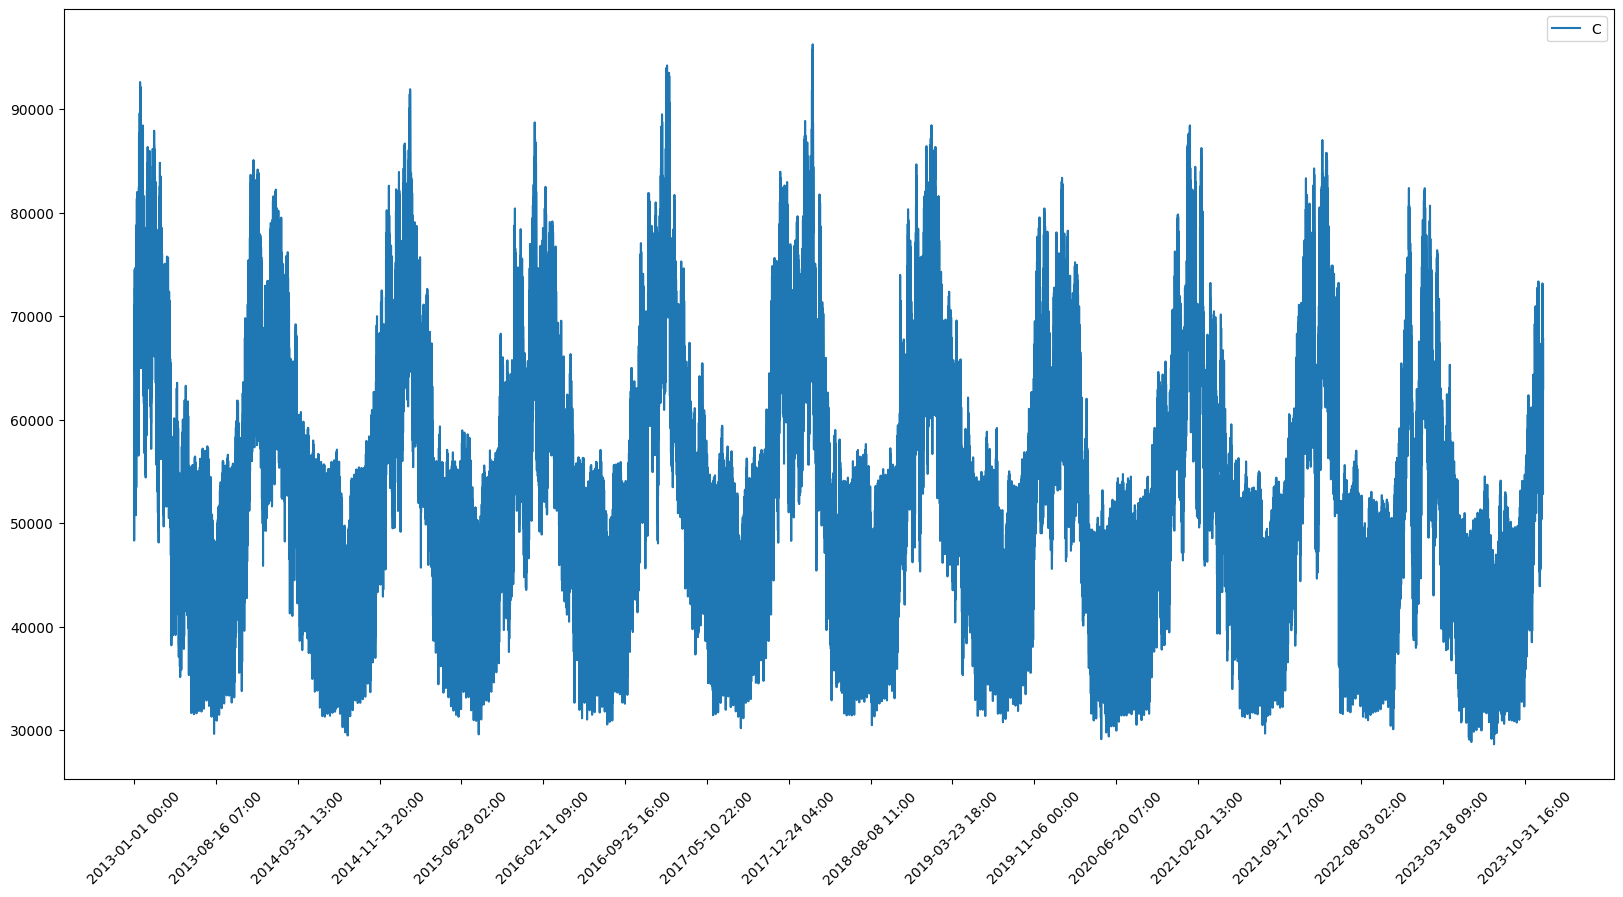

In [26]:
#print plot just conso_national
plt.figure(figsize=(20,10))
plt.plot(model_national["Consommation"])
plt.legend("Consommation nationale")
#just print key values from x label
plt.xticks(model_national.index[::10000], model_national.index[::10000], rotation=45)
plt.show()


# Création du modèle régional

In [24]:
model_Auvergne = pd.DataFrame()
model_Bourgogne = pd.DataFrame()
model_Bretagne = pd.DataFrame()
model_Centre = pd.DataFrame()
model_Est = pd.DataFrame()
model_Hauts = pd.DataFrame()
model_Paris = pd.DataFrame()
model_Normandie = pd.DataFrame()
model_Aquitaine = pd.DataFrame()
model_Occitanie = pd.DataFrame()
model_PACA = pd.DataFrame()

for region in REGIONS:
    df = pd.concat([conso_regional[["index", f"Consommation_{region}"]], nb_habitants[f"{region}"]], axis=1, join="inner")
    df = pd.concat([df, mean_temp[f"Temperature_{region}"]], axis=1, join="inner")
    df = df.set_index("index")
    if region == "Auvergne-Rhône-Alpes":
        model_Auvergne = df
    elif region == "Bourgogne-Franche-Comté":
        model_Bourgogne = df
    elif region == "Bretagne":
        model_Bretagne = df
    elif region == "Centre-Val-de-Loire":
        model_Centre = df
    elif region == "Grand-Est":
        model_Est = df
    elif region == "Hauts-de-France":
        model_Hauts = df
    elif region == "Ile-de-France":
        model_Paris = df
    elif region == "Normandie":
        model_Normandie = df
    elif region == "Nouvelle-Aquitaine":
        model_Aquitaine = df
    elif region == "Occitanie":
        model_Occitanie = df
    elif region == "PACA":
        model_PACA = df

In [25]:
model_PACA

,Consommation_PACA,PACA,Temperature_PACA
index,,,
2013-01-01 00:00:00,5570.0,3.660852e+06,6.100000
2013-01-01 00:30:00,5570.0,3.660854e+06,5.916667
2013-01-01 01:00:00,5698.0,3.660855e+06,5.733333
2013-01-01 01:30:00,5680.0,3.660857e+06,5.550000
2013-01-01 02:00:00,5577.0,3.660859e+06,5.366667
...,...,...,...
2022-09-15 22:00:00,3971.0,3.907415e+06,11.375904
2022-09-15 22:30:00,4009.0,3.907418e+06,11.375678
2022-09-15 23:00:00,4049.0,3.907420e+06,11.375452


In [26]:
#train test split of conso_national
train_conso = model_national[:"2018-12-31"]
test_conso = model_national["2019-01-01":]

In [ ]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

In [ ]:
autocorrelation_lag1 = df['#Passengers'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

In [ ]:
#forecast
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("1960-08", format='%Y-%m')]
train['train'] = train['#Passengers']
del train['Date']
del train['#Passengers']
test = df[df['Date'] >= pd.to_datetime("1960-08", format='%Y-%m')]
del test['Date']
test['test'] = test['#Passengers']
del test['#Passengers']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [27]:
#transform model in time series
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(train_conso["Consommation"], model="additive", period=365)
result.plot()
pyplot.show()

In [ ]:
#test sarima mdodel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)



In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
print(model.summary())

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

In [ ]:
#test prophet
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet

# prepare expected column names
def prepare_dataset(df, date_col, target_col):
    df = df[[date_col, target_col]]
    df.columns = ['ds', 'y']
    return df

# load the dataset
df = read_csv('./data/eco2mix/France/En-cours-Consolide.txt', sep='\t', encoding="latin-1")
# prepare expected column names
df = prepare_dataset(df, 'Date', 'Consommation')
# define the model
model = Prophet()
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2021-%02d' % i
    future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# plot forecast
model.plot(forecast)
pyplot.show()
